### In this file I will produce the data for feature selection 3, explain reasons for design choices<br>
specifically I make separate pickles for doubled data and single data, remove low variance and highly correlated features and fingerprints<br>
also I study reasons for data loss

In [1]:
import numpy as np
import pandas as pd
import _pickle as pickle
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [3]:
with open('./pickles/doubledData.pkl', 'rb') as inp:
    dataDoubled = pickle.load(inp)

with open('./pickles/singleData.pkl', 'rb') as inp:
    dataSingle = pickle.load(inp)

with open('./pickles/joinFrame.pkl', 'rb') as inp:
    drugs = pickle.load(inp)

In [52]:
# research for later: Figure out why
data[(data["Drug1"]=="mk-8776") & (data["Drug2"]=="bez-235")].head(2)

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA


In [54]:
data[(data["Drug2"]=="bez-235")]

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
8,9,5-fu,bez-235,A2058,4.010,3.380,3.210,7.140
9,10,5-fu,bez-235,A2058,0.880,3.290,3.120,7.050
10,11,5-fu,bez-235,A2058,3.110,3.430,3.260,7.190
11,12,5-fu,bez-235,A2058,2.040,5.250,5.080,9.010
80,81,abt-888,bez-235,A2058,8.270,8.280,-22.260,8.040
...,...,...,...,...,...,...,...,...
492105,492106,tic-10,bez-235,DIPG25,-6.507,-5.513,-1.332,1.246
492106,492107,eed-226,bez-235,DIPG25,-0.272,-3.171,-18.970,-5.120
492107,492108,hdaci-02,bez-235,DIPG25,31.664,30.934,29.447,29.025
492108,492109,gsk-2256098,bez-235,DIPG25,12.875,15.307,10.921,13.389


### Preparation of Fingerprint - Data

In [2]:
# getting chemical descriptors
chemDescr = pd.read_csv("../drugCombDBdata/descriptions/drug_chemical_info.csv")

#removing empty values
print(str(len(chemDescr[chemDescr["smilesString"]=="none"]))+" drugs with 'none' as smile")
print(str(len(chemDescr[pd.isna(chemDescr["smilesString"])]))+" drugs with NaN as smile")
print("     dropping both for now")


chemDescr = chemDescr[chemDescr["smilesString"]!="none"]
chemDescr = chemDescr[~pd.isna(chemDescr["smilesString"])]
chemDescr.reset_index(inplace=True)
chemDescr.head(2)

30 drugs with 'none' as smile
454 drugs with NaN as smile
     dropping both for now


,index,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
0,0,Bendamustine,CIDs00065628,bendamustine,358.26284,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
1,1,Lonidamine,CIDs00039562,lonidamine,321.15810,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O


In [15]:
chemDescr["mol-object"]=[Chem.MolFromSmiles(mol) for mol in chemDescr["smilesString"]]

maccsFrame = pd.DataFrame(chemDescr["drugName"])

maccsFrame["MACCSk"] = [np.array(Chem.MACCSkeys.GenMACCSKeys(mol)) for mol in chemDescr["mol-object"]]
maccsFrame.head(2)

,drugName,MACCSk
0,Bendamustine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Lonidamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
joinMaccs = pd.DataFrame([])
for i in range(len(maccsFrame)):
    joinMaccs = joinMaccs.append(pd.Series(maccsFrame.iloc[i,1]),ignore_index=True)
joinMaccs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [18]:
drugMACCS = maccsFrame.join(joinMaccs,how="left").drop(columns="MACCSk")
with open('./pickles/drugMACCS.pkl', 'wb') as outp:
    pickle.dump(drugMACCS, outp)
drugMACCS.head(2)

,drugName,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,Bendamustine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,Lonidamine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


### Studying the problem in the data

In [1]:
import pandas as pd
import numpy as np
import _pickle as pickle

chemDescr = pd.read_csv("../drugCombDBdata/descriptions/drug_chemical_info.csv")
data = pd.read_csv("../drugCombDBdata/synergy-score-data/REGRdrugcombs_scored.csv")

print(len(chemDescr)," Drugs and")
print(len(data)," records")

3059  Drugs and
498865  records


#### Demo Missing Datapoints

In [6]:
chemDescrNaN = chemDescr[pd.isna(chemDescr["smilesString"])]
print(len(chemDescrNaN))
chemDescrNaN.head(2)

454


,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
10,Pemetrexed disodium,CIDs135413520,NaN,0.0,NaN
11,Gemcitabine,CIDs00060750,NaN,0.0,NaN


In [3]:
chemDescrNone = chemDescr[chemDescr["smilesString"]=="none"]
print(len(chemDescrNone))
chemDescrNone.head(2)

30


,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
2888,PRAMIPEXOLE,CIDs00119570,none,0.0,none
2891,PYRIDOSTIGMINE BROMIDE,CIDs00007550,none,0.0,none


In [5]:
data[pd.isna(data["Drug1"])]
data[pd.isna(data["Drug2"])] #not too many

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
492920,492921,Amodiaquin dihydrochloride dihydrate,NaN,Huh-7,4.415,6.764,-1.451,-0.600
492934,492935,Amodiaquin dihydrochloride dihydrate,NaN,Mak,8.919,11.060,-3.333,8.485
492958,492959,Azithromycin,NaN,Huh-7,-6.447,-4.859,-0.099,0.101
492959,492960,Azithromycin,NaN,Huh-7,-2.744,-2.089,0.428,0.284
492960,492961,Azithromycin,NaN,Huh-7,-2.908,-0.452,-5.700,0.348
492972,492973,Azithromycin,NaN,Mak,1.150,1.164,-2.309,6.886
492973,492974,Azithromycin,NaN,Mak,-1.603,-2.016,-6.762,1.960
492974,492975,Azithromycin,NaN,Mak,7.501,6.475,1.230,9.639


In [2]:
counter = 0
for i in range(len( chemDescr )):
    if chemDescr.loc[i,"smilesString"]=="none":
        chemDescr.loc[i,"smilesString"] = "9999"
        counter+=1
    elif pd.isna(chemDescr.loc[i,"smilesString"]):
        chemDescr.loc[i,"smilesString"] = "9999"
        counter+=1
    #chemDescr[chemDescr["smilesString"]=="none"].loc[i,"smilesString"] = 1
print(counter," elements changed")
chemDescr.head(2)

484  elements changed


,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
0,Bendamustine,CIDs00065628,bendamustine,358.26284,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
1,Lonidamine,CIDs00039562,lonidamine,321.15810,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O


#### Combining

In [3]:
%%capture --no-display

#lowering strings
chemDescr["drugName"] = chemDescr["drugName"].str.lower()
data["Drug1"] = data["Drug1"].str.lower()
data["Drug2"] = data["Drug2"].str.lower()

joinDrugs = chemDescr[["drugName","smilesString"]]

#joining
d1_join = joinDrugs.set_index("drugName").add_prefix("D1 ")
d2_join = joinDrugs.set_index("drugName").add_prefix("D2 ")
dataSmiles = data.join(d1_join,on="Drug1",how="left")
dataSmiles = dataSmiles.join(d2_join,on="Drug2",how="left")   # later: inner join to keep only the matching ones

dataSmiles

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,D1 smilesString,D2 smilesString
0,1,5-fu,abt-888,A2058,1.720,6.260,-2.750,5.540,C1=C(C(=O)NC(=O)N1)F,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N
1,2,5-fu,abt-888,A2058,5.880,12.330,3.330,11.610,C1=C(C(=O)NC(=O)N1)F,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N
2,3,5-fu,abt-888,A2058,3.590,11.660,2.650,10.940,C1=C(C(=O)NC(=O)N1)F,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N
3,4,5-fu,abt-888,A2058,-0.850,5.150,-3.860,4.430,C1=C(C(=O)NC(=O)N1)F,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N
4,5,5-fu,azd1775,A2058,12.290,15.770,10.400,18.660,C1=C(C(=O)NC(=O)N1)F,CC(C)(C1=NC(=CC=C1)N2C3=NC(=NC=C3C(=O)N2CC=C)N...
...,...,...,...,...,...,...,...,...,...,...
498860,498861,mitomycin c,valproic acid sodium salt,DIPG25,-3.076,-11.124,-6.078,-6.367,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,9999
498861,498862,cyanein,valproic acid sodium salt,DIPG25,1.320,-1.091,-16.157,1.139,CC1CCCC=CC2CC(CC2C(C=CC(=O)O1)O)O,9999
498862,498863,erlotinib,valproic acid sodium salt,DIPG25,-15.768,-15.776,-25.465,-6.212,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,9999
498863,498864,bafilomycin a1,valproic acid sodium salt,DIPG25,2.208,10.567,-9.455,1.525,CC1CC(=CC=CC(C(OC(=O)C(=CC(=CC(C1O)C)C)OC)C(C)...,9999


#### Investigation of Missing Values

In [13]:
dataSmiles[(dataSmiles["D1 smilesString"]=="9999") | (dataSmiles["D2 smilesString"]=="9999")]

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,D1 smilesString,D2 smilesString
100,101,abt-888,oxaliplatin,A2058,-0.100,4.680,-4.320,2.750,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,9999
101,102,abt-888,oxaliplatin,A2058,-0.730,3.630,-5.370,1.700,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,9999
102,103,abt-888,oxaliplatin,A2058,-0.170,3.110,-5.890,1.180,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,9999
103,104,abt-888,oxaliplatin,A2058,2.220,6.590,-2.410,4.660,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,9999
112,113,abt-888,topotecan,A2058,3.690,3.260,-22.720,3.090,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,9999
...,...,...,...,...,...,...,...,...,...,...
498860,498861,mitomycin c,valproic acid sodium salt,DIPG25,-3.076,-11.124,-6.078,-6.367,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,9999
498861,498862,cyanein,valproic acid sodium salt,DIPG25,1.320,-1.091,-16.157,1.139,CC1CCCC=CC2CC(CC2C(C=CC(=O)O1)O)O,9999
498862,498863,erlotinib,valproic acid sodium salt,DIPG25,-15.768,-15.776,-25.465,-6.212,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,9999
498863,498864,bafilomycin a1,valproic acid sodium salt,DIPG25,2.208,10.567,-9.455,1.525,CC1CC(=CC=CC(C(OC(=O)C(=CC(=CC(C1O)C)C)OC)C(C)...,9999


In [4]:
dataSmiles = dataSmiles[~((dataSmiles["D1 smilesString"]=="9999") | (dataSmiles["D2 smilesString"]=="9999"))]

In [4]:
duplicateChecker = dataSmiles[["Drug1","Drug2","Cell line"]]
duplicateChecker = duplicateChecker.reset_index().drop(columns="index")
duplicateChecker.drop_duplicates() #not so much less actually

,Drug1,Drug2,Cell line
0,5-fu,abt-888,A2058
4,5-fu,azd1775,A2058
8,5-fu,bez-235,A2058
12,5-fu,bortezomib,A2058
16,5-fu,dasatinib,A2058
...,...,...,...
498859,rotenone,valproic acid sodium salt,DIPG25
498861,cyanein,valproic acid sodium salt,DIPG25
498862,erlotinib,valproic acid sodium salt,DIPG25
498863,bafilomycin a1,valproic acid sodium salt,DIPG25


#### Rebuilding the Decision Tree Here

At first for HSA

In [62]:
dataSet = dataSmiles[["Drug1","HSA"]]
dataSet = dataSet.reset_index().drop(columns="index")
print(len(dataSet)," records")
dataSet.head(2)

366127  records


,Drug1,HSA
0,5-fu,5.54
1,5-fu,11.61


In [105]:
with open('./pickles/drugMACCS.pkl', 'rb') as inp:
    drugMACCS = pickle.load(inp)
drugMACCS["drugName"] = drugMACCS["drugName"].str.lower()
drugMACCS.set_index("drugName",inplace=True)

#drop low variance features
dropSet = []
for i in range(167):
    if (np.mean(drugMACCS[i]) < 0.2) | (np.mean(drugMACCS[i]) > 0.8):
        dropSet.append(i)
len(dropSet)
drugMACCS.drop(columns=dropSet,inplace=True)
drugMACCS.head(2)

,38,42,53,57,62,65,66,72,74,75,...,149,150,151,152,153,154,155,157,159,160
drugName,,,,,,,,,,,,,,,,,,,,,
bendamustine,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
lonidamine,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [106]:
dataMACCS = dataSet.join(drugMACCS,on="Drug1",how="left")
dataMACCS.dropna(inplace=True)
dataMACCS.head(2)

,Drug1,HSA,38,42,53,57,62,65,66,72,...,149,150,151,152,153,154,155,157,159,160
0,5-fu,5.54,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,5-fu,11.61,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [101]:
#thats how you do mean
np.mean(abs(np.mean(y_test)-y_test))

5.807297550922636

In [108]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = dataMACCS.iloc[:,2:]
Y = dataMACCS.iloc[:,1]

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3)#stratify=Y

regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train)

np.mean(abs(regressor.predict(x_test)-y_test))

5.443115465183336

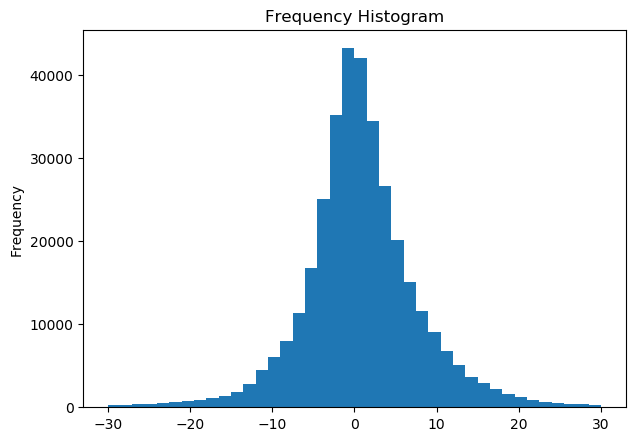

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(Y[(Y<30) & (Y>-30)],bins=40)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

Other KPIs

In [63]:
dataSetAltern = dataSmiles[["Drug1","ZIP","Bliss","Loewe"]]
dataSetAltern = dataSetAltern.reset_index().drop(columns="index")
print(len(dataSetAltern)," records")
dataSetAltern.head(2)

366127  records


,Drug1,ZIP,Bliss,Loewe
0,5-fu,1.72,6.26,-2.75
1,5-fu,5.88,12.33,3.33


In [74]:
with open('./pickles/drugMACCS.pkl', 'rb') as inp:
    drugMACCSAlt = pickle.load(inp)
drugMACCSAlt["drugName"] = drugMACCSAlt["drugName"].str.lower()
drugMACCSAlt.set_index("drugName",inplace=True)

#drop low variance features
dropSet = []
for i in range(167):
    if (np.mean(drugMACCSAlt[i]) < 0.23) | (np.mean(drugMACCSAlt[i]) > 0.8):
        dropSet.append(i)
len(dropSet)
drugMACCSAlt.drop(columns=dropSet,inplace=True)
drugMACCSAlt.head(2)

,38,57,62,65,66,72,75,77,79,80,...,149,150,151,152,153,154,155,157,159,160
drugName,,,,,,,,,,,,,,,,,,,,,
bendamustine,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
lonidamine,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [75]:
dataMACCSAlt = dataSetAltern.join(drugMACCSAlt,on="Drug1",how="left")
dataMACCSAlt.dropna(inplace=True)
dataMACCSAlt.head(2)

,Drug1,ZIP,Bliss,Loewe,38,57,62,65,66,72,...,149,150,151,152,153,154,155,157,159,160
0,5-fu,1.72,6.26,-2.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,5-fu,5.88,12.33,3.33,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [78]:
X = dataMACCSAlt.iloc[:,4:]
Y = dataMACCSAlt.iloc[:,1] # change here 1: ZIP, 2:Bliss, 3:Loewe

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3)#stratify=Y

regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train)

np.mean(abs(regressor.predict(x_test)-y_test)) # ZIP error with just 1 variable: ~95

91.26255892691053

In [92]:
np.mean(abs(regressor.predict(X_train)-Y_train))

74.35651261985149

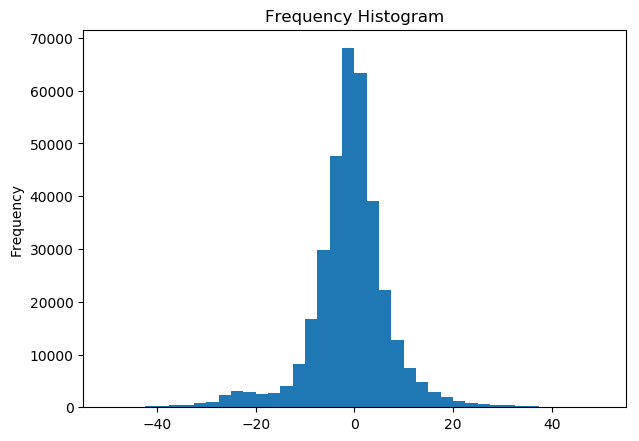

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(Y[(Y<50) & (Y>-50)],bins=40)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [94]:
# Stratification on categorical values ==> cell lines rather than numerical things

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.